# Custom loss function in GBM demo

In H2O GBM implementation distributions, and loss functions are tightly coupled. In the algorithm, a loss function is specified using the distribution parameter. When specifying the distribution, the loss function is automatically selected as well.

Usually, the loss functions are symmetric around some value. For example, Gaussian "Normal" distribution use Square Error Loss, which is symmetric around mean.

![gaussian](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/gaussian.png)

In some prediction problems, the asymmetry in loss function can improve results. For example, if we know that some kind of error is more undesirable than others. We can use weights as well. However, it is not easy to use for more complicated calculation, and it can not cover all possibilities well.

You can get more information about customization of loss function [here](https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d), where is an example using LightGBM library. XGBoost library also provides this possibility.

In H2O you can upload custom distribution now and also customized loss function calculation. See the example below.

In [2]:
# import h2o and other libraries
import h2o
import pandas as pd
import datetime

from h2o.estimators.gbm import H2OGradientBoostingEstimator

# init h2o
h2o.init()

versionFromGradle='3.25.0',projectVersion='3.25.0.99999',branch='maurever_PUBDEV-4076_custom_loss_function',lastCommitHash='89feb962ee4c89ab847ed3eb052062ca091e9c69',gitDescribe='jenkins-master-4714-38-g89feb962ee-dirty',compiledOn='2019-07-02 15:02:01',compiledBy='mori'
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-post-Debian-5); OpenJDK 64-Bit Server VM (build 11.0.3+7-post-Debian-5, mixed mode, sharing)
  Starting server from /home/mori/Documents/h2o/code/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpqqdbiwns
  JVM stdout: /tmp/tmpqqdbiwns/h2o_mori_started_from_python.out
  JVM stderr: /tmp/tmpqqdbiwns/h2o_mori_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.25.0.99999
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_mori_346k5q
H2O cluster total nodes:,1
H2O cluster free memory:,5.768 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data 

To demonstrate how to customize loss function, we use [Store Item Demand Forecasting training dataset](https://www.kaggle.com/c/demand-forecasting-kernels-only/data) from Kaggle. 

**Data fields:**

- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

The goal is to forecast how many items will be sale in a store on a specific date. This task can be useful for example, for planning how many items to store in which shop to be available for customers, however with costs for space in the shop as low as possible. 

In [3]:
# load data 
data = pd.read_csv("../../smalldata/demos/item_demand.csv")
print(data.shape)

(913000, 4)


## Data preprocessing

To predict a specific value, we need to prepare some new features. First split date to year, month, day. Then we make "lag" features one year back. From these features, we aggregate some other values.

In [4]:
# Transform date column
def prepare_date(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column])
    index = pd.DatetimeIndex(data[date_column])
    data["year"] = index.year
    data["month"] = index.month
    data["day"] = index.day
    return data

# Create new features (lags, aggregated values based on lags)
def group_by_agg_lags(data):
    g = data.groupby(["store", "item"]).sales

    # lags older than 92 to be aple to prepare test data correctly 
    for i in range(92,366):
        data["lag_"+str(i)] = g.shift(i)
    data.dropna(inplace=True, axis=0)
    
    data["mean_last_year_week_7"] = data.iloc[:,266:274].mean(axis=1)
    data["mean_last_year_week_6"] = data.iloc[:,267:275].mean(axis=1)
    data["mean_last_year_week_5"] = data.iloc[:,268:276].mean(axis=1)
    data["mean_last_year_week_4"] = data.iloc[:,269:277].mean(axis=1)
    data["mean_last_year_week_3"] = data.iloc[:,270:278].mean(axis=1)
    data["mean_last_year_week_2"] = data.iloc[:,271:279].mean(axis=1)
    data["mean_last_year_week_1"] = data.iloc[:,272:280].mean(axis=1)
    data["moving_mean_last_year_week"] = data.iloc[:,280:287].mean(axis=1)
    data["sum_last_year_week"] = data.iloc[:,272:280].sum(axis=1)
    return data

In [5]:
# prepare date columns
data = prepare_date(data, "date")

# aggregate data, prepare lags, remove null rows
data = group_by_agg_lags(data)
print("New data shape:")
print(data.shape)

# split to train and test
train = data[data.date <= "2017-09-30"]
print("Training data shape:")
print(train.shape)

# last 3 month for testing
test = data[data.date > "2017-09-30"]
print("Testing data shape:")
print(test.shape)

# Upload prepared data to h2o 
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

New data shape:
(730500, 290)
Training data shape:
(684500, 290)
Testing data shape:
(46000, 290)
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Types of error

There could be two types of error:
- there are the fewer amount of items in a store
- there are the more or perfect amount of items in a store

If we use traditional Gaussian distribution to train model, the algorithm penalizes these two errors similarly. But for a manager of the stores could be more expensive not to sell an item, than store more items in a particular shop. Thus the first error is more critical to penalize during the training than the second one.

In [6]:
# evaluate number of good predictions
def evaluate(test, predictions):
    predictions["actual"] = test.sales.values
    predictions.columns = ["prediction", "actual"]
    predictions["residual"] = predictions.actual - predictions.prediction
    predictions["fit"] = 0
    predictions.loc[predictions.residual < 0, "fit"] = 0
    predictions.loc[predictions.residual >= 0, "fit"] = 1
    items = predictions.shape[0]
    more_or_perfect = sum(predictions.fit)
    less = items - more_or_perfect
    return (items, less, more_or_perfect)

# print result of evaluation
def print_evaluation(predictions, less, more_or_perfect):
    import matplotlib.pyplot as plt
    import numpy as np
    # set if no figure on output
    # %matplotlib inline

    #create scatter plot to show numbers of the errors
    name = ["fewer", "more or perfect"]
    count = [less, more_or_perfect]
    rank = [-4, 4]

    fig, ax = plt.subplots()
    ax.axis([-10,10,-14000,90000])
    ax.scatter(rank,count,s=count,marker='o', c=["red","green"])

    for n,c,r in zip(name, count, rank):
        plt.annotate("{}".format(c),xy=(r, c), ha="center", va="center", color="white", weight='bold', size=15)
        plt.annotate(n ,xy=(r, c), xytext=(0,15),
                 textcoords="offset points", ha="center", va="bottom", color="white", weight='bold', size=13)
    plt.title("Ratio between acceptable and nonacceptable predictions", weight='bold', size=15)
    plt.axis('off')
    plt.show()

    #create histogram of residuals 
    n, bins, patches = plt.hist(x=predictions.residual, bins='auto', color='#0504aa')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value of residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of residuals \n mean='+str(np.mean(predictions.residual)), weight='bold', size=15)
    maxfreq = n.max()
    plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## Gaussian Distribution - symmetric

To use Gaussian distribution and Squared error loss function we need only set the ``distribution`` parameter to ``gaussian``.

From the images below, we can see the numbers of two types of error are similar. Also, the distribution of residuals is symmetric around zero value. 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


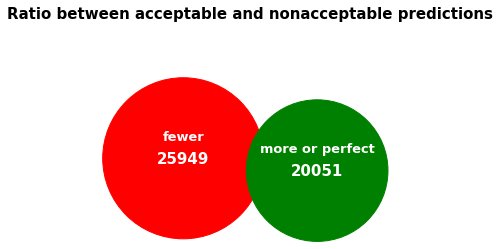

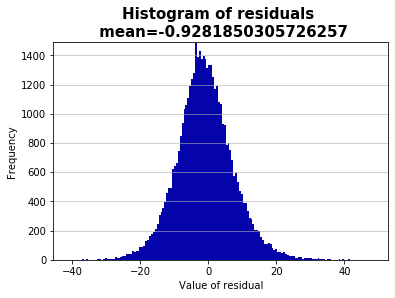

In [7]:
# Train GBM model with gaussian 
gbm_gaussian = H2OGradientBoostingEstimator(model_id="sales_model",
                                     ntrees=50,
                                     max_depth=5,
                                     score_each_iteration=True,
                                     distribution="gaussian")
gbm_gaussian.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

predictions = gbm_gaussian.predict(test_data=test_h2o).as_data_frame()

items, less, more_or_perfect = evaluate(test, predictions)

print_evaluation(predictions, less, more_or_perfect)

## Custom Gaussian Distribution - asymmetric

To use Custom distribution and implement asymmetric loss function we need only set the ``distribution`` parameter to ``custom``. Also, we need to upload our implementation of distribution and set reference to this distribution to ``custom_distribution_func`` parameter.

We can implement an entirely own version of a distribution. However, we need to implement only different loss function calculation and that it is the reason to inherit from predefined ``CustomDistributionGaussian`` class and override only ``gradient`` function.

In the images below, we can see the number of the first type error is rapidly lower than the amount of the second type error. On the residual histogram, we can also see mean residual value is a positive value, and even more values are shifted to the right.

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


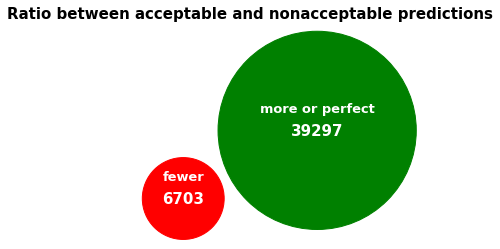

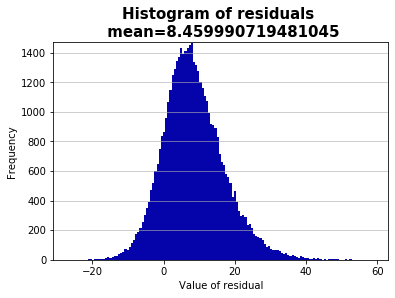

In [8]:
# Import predefined Gaussian Distribution
from h2o.utils.distributions import CustomDistributionGaussian

# Define asymmetric loss distribution from Gaussian distribution 
class AsymmetricLossDistribution(CustomDistributionGaussian):

    def gradient(self, y, f):
        error = y - f
        # more predicted items is better error than the fewer predicted items
        return 10 * error if error < 0 else 0.5 * error
    

name = "asymetric"
distribution_ref = h2o.upload_custom_distribution(AsymmetricLossDistribution, func_name="custom_"+name,
                                          func_file="custom_"+name+".py")

gbm_custom = H2OGradientBoostingEstimator(model_id="custom_sales_model",
                                     ntrees=50,
                                     max_depth=5,
                                     score_each_iteration=True,
                                     distribution="custom",
                                     custom_distribution_func=distribution_ref)
gbm_custom.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

predictions = gbm_custom.predict(test_data=test_h2o).as_data_frame()
items, less, more_or_perfect = evaluate(test, predictions)
print_evaluation(predictions, less, more_or_perfect)

## Conclusion

We used a simple loss function improvement, but the result is significant. In this example, the resulting metric (for instance MSE) is not important for this demonstration (it also evaluate our error symmetrically). If you want to measure the performance of model asymmetrically, you can define your asymmetric custom metric too (more information and example [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/custom_metric_func.html)). 